# Image Captioning Final Project

In this final project you will define and train an image-to-caption model, that can produce descriptions for real world images!

<img src="images/encoder_decoder.png" style="width:70%">

Model architecture: CNN encoder and RNN decoder. 
(https://research.googleblog.com/2014/11/a-picture-is-worth-thousand-coherent.html)

# Import stuff

In [1]:
import sys
sys.path.append("..")

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
L = keras.layers
K = keras.backend
import utils
import time
import zipfile
import json
from collections import defaultdict
import re
import os
from keras_utils import reset_tf_session
import tqdm_utils

Using TensorFlow backend.


# Prepare the storage for model checkpoints

In [3]:
# Leave USE_GOOGLE_DRIVE = False if you're running locally!
# We recommend to set USE_GOOGLE_DRIVE = True in Google Colab!
# If set to True, we will mount Google Drive, so that you can restore your checkpoint 
# and continue trainig even if your previous Colab session dies.
# If set to True, follow on-screen instructions to access Google Drive (you must have a Google account).
USE_GOOGLE_DRIVE = False

def mount_google_drive():
    from google.colab import drive
    mount_directory = "/content/gdrive"
    drive.mount(mount_directory)
    drive_root = mount_directory + "/" + list(filter(lambda x: x[0] != '.', os.listdir(mount_directory)))[0] + "/colab"
    return drive_root

CHECKPOINT_ROOT = ""
if USE_GOOGLE_DRIVE:
    CHECKPOINT_ROOT = mount_google_drive() + "/"

def get_checkpoint_path(epoch=None):
    if epoch is None:
        return os.path.abspath(CHECKPOINT_ROOT + "weights")
    else:
        return os.path.abspath(CHECKPOINT_ROOT + "weights_{}".format(epoch))
      
# example of checkpoint dir
print(get_checkpoint_path(10))

D:\intro-to-dl\week6\weights_10


# Download data

Takes 10 hours and 20 GB. We've downloaded necessary files for you.

Relevant links (just in case):
- train images http://msvocds.blob.core.windows.net/coco2014/train2014.zip
- validation images http://msvocds.blob.core.windows.net/coco2014/val2014.zip
- captions for both train and validation http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip

# Extract image features

We will use pre-trained InceptionV3 model for CNN encoder (https://research.googleblog.com/2016/03/train-your-own-image-classifier-with.html) and extract its last hidden layer as an embedding:

<img src="images/inceptionv3.png" style="width:70%">

In [4]:
IMG_SIZE = 300

In [5]:
# we take the last hidden layer of IncetionV3 as an image embedding
def get_cnn_encoder():
    K.set_learning_phase(False)
    model = keras.applications.InceptionV3(include_top=False)
    preprocess_for_model = keras.applications.inception_v3.preprocess_input

    model = keras.models.Model(model.inputs, keras.layers.GlobalAveragePooling2D()(model.output))
    return model, preprocess_for_model

Features extraction takes too much time on CPU:
- Takes 16 minutes on GPU.
- 25x slower (InceptionV3) on CPU and takes 7 hours.
- 10x slower (MobileNet) on CPU and takes 3 hours.

```python
# load pre-trained model
reset_tf_session()
encoder, preprocess_for_model = get_cnn_encoder()

# extract train features
train_img_embeds, train_img_fns = utils.apply_model(
    "train2014.zip", encoder, preprocess_for_model, input_shape=(IMG_SIZE, IMG_SIZE))
utils.save_pickle(train_img_embeds, "train_img_embeds.pickle")
utils.save_pickle(train_img_fns, "train_img_fns.pickle")

# extract validation features
val_img_embeds, val_img_fns = utils.apply_model(
    "val2014.zip", encoder, preprocess_for_model, input_shape=(IMG_SIZE, IMG_SIZE))
utils.save_pickle(val_img_embeds, "val_img_embeds.pickle")
utils.save_pickle(val_img_fns, "val_img_fns.pickle")

# sample images for learners
def sample_zip(fn_in, fn_out, rate=0.01, seed=42):
    np.random.seed(seed)
    with zipfile.ZipFile(fn_in) as fin, zipfile.ZipFile(fn_out, "w") as fout:
        sampled = filter(lambda _: np.random.rand() < rate, fin.filelist)
        for zInfo in sampled:
            fout.writestr(zInfo, fin.read(zInfo))
            
sample_zip("train2014.zip", "train2014_sample.zip")
sample_zip("val2014.zip", "val2014_sample.zip")
```

In [6]:
# load prepared embeddings
train_img_embeds = utils.read_pickle("train_img_embeds.pickle")
train_img_fns = utils.read_pickle("train_img_fns.pickle")
val_img_embeds = utils.read_pickle("val_img_embeds.pickle")
val_img_fns = utils.read_pickle("val_img_fns.pickle")
# check shapes
print(train_img_embeds.shape, len(train_img_fns))
print(val_img_embeds.shape, len(val_img_fns))

(82783, 2048) 82783
(40504, 2048) 40504


# Extract captions for images

In [8]:
# extract captions from zip
def get_captions_for_fns(fns, zip_fn, zip_json_path):
    zf = zipfile.ZipFile(zip_fn)
    j = json.loads(zf.read(zip_json_path).decode("utf8"))
    id_to_fn = {img["id"]: img["file_name"] for img in j["images"]}
    fn_to_caps = defaultdict(list)
    for cap in j['annotations']:
        fn_to_caps[id_to_fn[cap['image_id']]].append(cap['caption'])
    fn_to_caps = dict(fn_to_caps)
    return list(map(lambda x: fn_to_caps[x], fns))
    
train_captions = get_captions_for_fns(train_img_fns, "captions_train-val2014.zip", 
                                      "annotations/captions_train2014.json")

val_captions = get_captions_for_fns(val_img_fns, "captions_train-val2014.zip", 
                                      "annotations/captions_val2014.json")

# check shape
print(len(train_img_fns), len(train_captions))
print(len(val_img_fns), len(val_captions))

82783 82783
40504 40504


# Prepare captions for training

In [9]:
# preview captions data
train_captions[:2]

[['A long dirt road going through a forest.',
  'A SCENE OF WATER AND A PATH WAY',
  'A sandy path surrounded by trees leads to a beach.',
  'Ocean view through a dirt road surrounded by a forested area. ',
  'dirt path leading beneath barren trees to open plains'],
 ['A group of zebra standing next to each other.',
  'This is an image of of zebras drinking',
  'ZEBRAS AND BIRDS SHARING THE SAME WATERING HOLE',
  'Zebras that are bent over and drinking water together.',
  'a number of zebras drinking water near one another']]

In [10]:
# special tokens  
UNK = "#UNK#"
START = "#START#"
END = "#END#"
PAD = "#PAD#"

# split sentence into tokens (split into lowercased words)
def split_sentence(sentence):
    return list(filter(lambda x: len(x) > 0, re.split('\W+', sentence.lower())))

def generate_vocabulary(train_captions):
    """
    Return {token: index} for all train tokens (words) that occur 5 times or more, 
        `index` should be from 0 to N, where N is a number of unique tokens in the resulting dictionary.
    Use `split_sentence` function to split sentence into tokens.
    Also, add PAD (for batch padding), UNK (unknown, out of vocabulary), 
        START (start of sentence) and END (end of sentence) tokens into the vocabulary.
    """
    vocab = [PAD, UNK, START, END]
    for img_captions in train_captions:
        for caption in img_captions:
            words = split_sentence(caption)
            for word in words:
                if word not in vocab:
                    vocab.append(word)

    return {token: index for index, token in enumerate(sorted(vocab))}
    
def caption_tokens_to_indices(captions, vocab):
    """
    `captions` argument is an array of arrays:
    [
        [
            "image1 caption1",
            "image1 caption2",
            ...
        ],
        [
            "image2 caption1",
            "image2 caption2",
            ...
        ],
        ...
    ]
    Use `split_sentence` function to split sentence into tokens.
    Replace all tokens with vocabulary indices, use UNK for unknown words (out of vocabulary).
    Add START and END tokens to start and end of each sentence respectively.
    For the example above you should produce the following:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    """
    res = []
    for img_captions in captions:
        arr_img = []
        for caption in img_captions:
            temp = [vocab[START]]
            words = split_sentence(caption)
            for word in words:
                if word in vocab.keys():
                    temp.append(vocab[word])
                else:
                    temp.append(vocab[UNK])
            temp.append(vocab[END])
            arr_img.append(temp)
        res.append(arr_img)
    return res

In [11]:
# prepare vocabulary
if "vocab.pickle" not in os.listdir():
    vocab = generate_vocabulary(train_captions)
    utils.save_pickle(vocab, "vocab.pickle")
else:
    vocab = utils.read_pickle("vocab.pickle")
    
if "vocab_inverse.pickle" not in os.listdir():
    vocab_inverse = {idx: w for w, idx in vocab.items()}
    utils.save_pickle(vocab_inverse, "vocab_inverse.pickle")
else:
    vocab_inverse = utils.read_pickle("vocab_inverse.pickle")
print(len(vocab))

23133


In [12]:
# replace tokens with indices
train_captions_indexed = caption_tokens_to_indices(train_captions, vocab)
val_captions_indexed = caption_tokens_to_indices(val_captions, vocab)

In [13]:
print(train_captions_indexed[0])

[[2, 272, 11707, 5940, 16692, 8773, 20550, 272, 8050, 0], [2, 272, 17241, 13540, 22317, 868, 272, 14332, 22373, 0], [2, 272, 17103, 14332, 19865, 3143, 21093, 11311, 20697, 272, 1899, 0], [2, 13508, 22015, 20550, 272, 5940, 16692, 19865, 3143, 272, 8052, 1097, 0], [2, 5940, 14332, 11310, 2095, 1756, 21093, 20697, 13672, 14944, 0]]


Captions have different length, but we need to batch them, that's why we will add PAD tokens so that all sentences have an equal length. 

We will crunch LSTM through all the tokens, but we will ignore padding tokens during loss calculation.

In [14]:
# we will use this during training
def batch_captions_to_matrix(batch_captions, pad_idx, max_len=None):
    """
    `batch_captions` is an array of arrays:
    [
        [vocab[START], ..., vocab[END]],
        [vocab[START], ..., vocab[END]],
        ...
    ]
    Put vocabulary indexed captions into np.array of shape (len(batch_captions), columns),
        where "columns" is max(map(len, batch_captions)) when max_len is None
        and "columns" = min(max_len, max(map(len, batch_captions))) otherwise.
    Add padding with pad_idx where necessary.
    Input example: [[1, 2, 3], [4, 5]]
    Output example: np.array([[1, 2, 3], [4, 5, pad_idx]]) if max_len=None
    Output example: np.array([[1, 2], [4, 5]]) if max_len=2
    Output example: np.array([[1, 2, 3], [4, 5, pad_idx]]) if max_len=100
    Try to use numpy, we need this function to be fast!
    """
    if max_len is None:
        columns = max(map(len, batch_captions))
    else:
        columns = min(max_len, max(map(len, batch_captions)))
    matrix = np.ones(shape=(len(batch_captions), columns))*pad_idx
    for i, arr in enumerate(batch_captions):
        l = min(columns, len(batch_captions[i]))
        matrix[i, :l] = batch_captions[i][:l]
    return matrix

# Training

## Define architecture

Since our problem is to generate image captions, RNN text generator should be conditioned on image. The idea is to use image features as an initial state for RNN instead of zeros. 

Remember that you should transform image feature vector to RNN hidden state size by fully-connected layer and then pass it to RNN.

During training we will feed ground truth tokens into the lstm to get predictions of next tokens. 

Notice that we don't need to feed last token (END) as input (http://cs.stanford.edu/people/karpathy/):

<img src="images/encoder_decoder_explained.png" style="width:50%">

In [15]:
print(train_img_embeds.shape)

(82783, 2048)


In [16]:
IMG_EMBED_SIZE = train_img_embeds.shape[1]
IMG_EMBED_BOTTLENECK = 128
WORD_EMBED_SIZE = 100
LSTM_UNITS = 300
LOGIT_BOTTLENECK = 120
pad_idx = vocab[PAD]

In [17]:
train_captions_indexed = np.array(train_captions_indexed)
val_captions_indexed = np.array(val_captions_indexed)

In [18]:
# generate batch via random sampling of images and captions for them,
# we use `max_len` parameter to control the length of the captions (truncating long captions)
def generate_batch(images_embeddings, indexed_captions, batch_size, max_len=None):
    """
    `images_embeddings` is a np.array of shape [number of images, IMG_EMBED_SIZE].
    `indexed_captions` holds 5 vocabulary indexed captions for each image:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    Generate a random batch of size `batch_size`.
    Take random images and choose one random caption for each image.
    Remember to use `batch_captions_to_matrix` for padding and respect `max_len` parameter.
    Return feed dict {decoder.img_embeds: ..., decoder.sentences: ...}.
    """
    idxs = np.random.choice(len(images_embeddings), batch_size, replace=False)
    batch_image_embeddings = images_embeddings[idxs] ### YOUR CODE HERE ###
    
    ### YOUR CODE HERE ###
    batch_captions = [caption[np.random.randint(5)] for caption in indexed_captions[idxs]]
    batch_captions_matrix = batch_captions_to_matrix(batch_captions, pad_idx, max_len)
    return {decoder.img_embeds: batch_image_embeddings, 
            decoder.sentences: batch_captions_matrix}

In [19]:
indices = np.arange(val_img_embeds.shape[0])
np.random.shuffle(indices)
num_cut_val_to_train = 20000

In [20]:
train_img_embeds = np.concatenate((train_img_embeds, val_img_embeds[:20000]), axis=0)
train_captions_indexed = np.concatenate((train_captions_indexed, val_captions_indexed[:20000]), axis=0)

In [21]:
val_img_embeds = val_img_embeds[20000:]
val_captions_indexed = val_captions_indexed[20000:]

In [22]:
batch_size = 64
n_epochs = 20
num_batches_train = train_img_embeds.shape[0]//batch_size
n_batches_per_epoch = num_batches_train if train_img_embeds.shape[0]/batch_size == 0 else num_batches_train + 1
num_batches_val = val_img_embeds.shape[0]//batch_size
n_validation_batches = num_batches_val if val_img_embeds.shape[0]/batch_size == 0 else num_batches_val + 1
MAX_LEN = 25

In [177]:
# remember to reset your graph if you want to start building it from scratch!
s = reset_tf_session()
tf.set_random_seed(42)

Here we define decoder graph.

We use Keras layers where possible because we can use them in functional style with weights reuse like this:
```python
dense_layer = L.Dense(42, input_shape=(None, 100) activation='relu')
a = tf.placeholder('float32', [None, 100])
b = tf.placeholder('float32', [None, 100])
dense_layer(a)  # that's how we applied dense layer!
dense_layer(b)  # and again
```

Here's a figure to help you with flattening in decoder:
<img src="images/flatten_help.jpg" style="width:80%">

In [178]:
class decoder:
    # [batch_size, IMG_EMBED_SIZE] of CNN image features
    img_embeds = tf.placeholder('float32', [None, IMG_EMBED_SIZE])
    # [batch_size, time steps] of word ids
    sentences = tf.placeholder('int32', [None, None])
    
    # we use bottleneck here to reduce the number of parameters
    # image embedding -> bottleneck
    img_embed_to_bottleneck = L.Dense(IMG_EMBED_BOTTLENECK, 
                                      input_shape=(None, IMG_EMBED_SIZE), 
                                      activation='elu')
    # image embedding bottleneck -> lstm initial state
    img_embed_bottleneck_to_h0 = L.Dense(LSTM_UNITS,
                                         input_shape=(None, IMG_EMBED_BOTTLENECK),
                                         activation='elu')
    # word -> embedding
    word_embed = L.Embedding(len(vocab), WORD_EMBED_SIZE)
    # lstm cell 
    lstm_cell = L.LSTMCell(LSTM_UNITS)
    
    # we use bottleneck here to reduce model complexity
    # lstm output -> logits bottleneck
    token_logits_bottleneck = L.Dense(LOGIT_BOTTLENECK, 
                                      input_shape=(None, LSTM_UNITS),
                                      activation="elu")
    # logits bottleneck -> logits for next token prediction
    token_logits = L.Dense(len(vocab),
                           input_shape=(None, LOGIT_BOTTLENECK))
    
    # initial lstm cell state of shape (None, LSTM_UNITS),
    # we need to condition it on `img_embeds` placeholder.
    c0 = h0 = img_embed_bottleneck_to_h0(img_embed_to_bottleneck(img_embeds))

    # embed all tokens but the last for lstm input,
    # remember that L.Embedding is callable,
    # use `sentences` placeholder as input.
    word_embeds = word_embed(sentences[:, :-1])

    # during training we use ground truth tokens `word_embeds` as context for next token prediction.
    # `out_hidden_states` has a shape of [batch_size, time steps, LSTM_UNITS].
    lstm = L.RNN(lstm_cell, return_sequences=True, return_state=True)
    out_hidden_states, _, _ = lstm(word_embeds, initial_state=[c0, h0])
    # now we need to calculate token logits for all the hidden states
    
    # first, we reshape `hidden_states` to [-1, LSTM_UNITS]
    flat_hidden_states = tf.reshape(out_hidden_states, shape=(-1, LSTM_UNITS))

    # then, we calculate logits for next tokens using `token_logits_bottleneck` and `token_logits` layers
    flat_token_logits = token_logits(token_logits_bottleneck(flat_hidden_states))

    # then, we flatten the ground truth token ids.
    # remember, that we predict next tokens for each time step,
    # use `sentences` placeholder.
    flat_ground_truth = tf.reshape(sentences[:, 1:], shape=(-1,))

    # compute cross-entropy between `flat_ground_truth` and `flat_token_logits` predicted by lstm
    xent = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=flat_ground_truth, 
        logits=flat_token_logits
    )

    loss = tf.reduce_mean(xent) 

In [179]:
# define optimizer operation to minimize the loss
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_step = optimizer.minimize(decoder.loss)

saver = tf.train.Saver()

# intialize all variables
#s.run(tf.global_variables_initializer())

## Training loop
Evaluate train and validation metrics through training and log them. Ensure that loss decreases.

Look at the training and validation loss, they should be decreasing!

In [54]:
# actual training loop
# truncate long captions to speed up training

# to make training reproducible
np.random.seed(42)
val_loss_min = 1e6

for epoch in range(n_epochs):
    
    train_loss = 0
    pbar = tqdm_utils.tqdm_notebook_failsafe(range(n_batches_per_epoch))
    counter = 0
    for _ in pbar:
        train_loss += s.run([decoder.loss, train_step], 
                            generate_batch(train_img_embeds, 
                                           train_captions_indexed, 
                                           batch_size, 
                                           MAX_LEN))[0]
        counter += 1
        pbar.set_description("Training loss: %f" % (train_loss / counter))
        
    train_loss /= n_batches_per_epoch
    
    val_loss = 0
    for _ in range(n_validation_batches):
        val_loss += s.run(decoder.loss, generate_batch(val_img_embeds,
                                                       val_captions_indexed, 
                                                       batch_size, 
                                                       MAX_LEN))
    val_loss /= n_validation_batches
    
    print('Epoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

    # save weights after finishing epoch
    if val_loss_min > val_loss:
        saver.save(s, get_checkpoint_path())
    
print("Finished!")

Epoch: 0, train loss: 2.6907502602076026, val loss: 2.190366097699816


Epoch: 1, train loss: 1.9956092880493677, val loss: 1.9025902967215327


Epoch: 2, train loss: 1.8022277868105792, val loss: 1.7799945093018243


Epoch: 3, train loss: 1.7049725082416463, val loss: 1.6987765173303004


Epoch: 4, train loss: 1.6323655265502883, val loss: 1.6315299395088838


Epoch: 5, train loss: 1.5849494156178323, val loss: 1.6331278208260225


Epoch: 6, train loss: 1.5632961681889717, val loss: 1.595801425128711


Epoch: 7, train loss: 1.5455072198531696, val loss: 1.6044980432385596


Epoch: 8, train loss: 1.5191190059425526, val loss: 1.5785776139048402


Epoch: 9, train loss: 1.501155242379546, val loss: 1.563722815097678


Epoch: 10, train loss: 1.4943652862629588, val loss: 1.540515022857167


Epoch: 11, train loss: 1.480421706644417, val loss: 1.5416196736962624


Epoch: 12, train loss: 1.4636670967116303, val loss: 1.5324675858577834


Epoch: 13, train loss: 1.4581925616614697, val loss: 1.5467295984612819


Epoch: 14, train loss: 1.4463973210134067, val loss: 1.5156052417101518


Epoch: 15, train loss: 1.4475309312120914, val loss: 1.528619188014592


Epoch: 16, train loss: 1.4402244403531512, val loss: 1.4994200126404331


Epoch: 17, train loss: 1.4188688294973646, val loss: 1.515857515676742


Epoch: 18, train loss: 1.4161630733817778, val loss: 1.504249704589725


Epoch: 19, train loss: 1.413601036349388, val loss: 1.525154702388609
Finished!


# Applying model

Here we construct a graph for our final model.

It will work as follows:
- take an image as an input and embed it
- condition lstm on that embedding
- predict the next token given a START input token
- use predicted token as an input at next time step
- iterate until you predict an END token

In [180]:
class final_model:
    # CNN encoder
    encoder, preprocess_for_model = get_cnn_encoder()
    saver.restore(s, get_checkpoint_path())
    
    # containers for current lstm state
    lstm_c = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="cell")
    lstm_h = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="hidden")

    # input images
    input_images = tf.placeholder('float32', [1, IMG_SIZE, IMG_SIZE, 3], name='images')

    # get image embeddings
    img_embeds = encoder(input_images)

    # initialize lstm state conditioned on image
    init_c = init_h = decoder.img_embed_bottleneck_to_h0(decoder.img_embed_to_bottleneck(img_embeds))
    init_lstm = tf.assign(lstm_c, init_c), tf.assign(lstm_h, init_h)
    
    # current word index
    current_word = tf.placeholder('int32', [1, 1], name='current_input')

    # embedding for current word
    word_embed = decoder.word_embed(current_word)
    
    # compute lstm 
    out_hidden, new_h, new_c = decoder.lstm(word_embed, initial_state=(lstm_h, lstm_c))

    # compute logits for next token
    new_logits = decoder.token_logits(decoder.token_logits_bottleneck(out_hidden))
    
    # compute probabilities for next token
    new_probs = tf.nn.softmax(new_logits)

    # assign state_h and state_c for next prediction
    assign_c = tf.assign(lstm_c, tf.reshape(new_c, shape=(1, LSTM_UNITS)))
    assign_h = tf.assign(lstm_h, tf.reshape(new_h, shape=(1, LSTM_UNITS)))

INFO:tensorflow:Restoring parameters from D:\intro-to-dl\week6\weights


In [181]:
# this is an actual prediction loop
def generate_caption(image, max_len=20):
    """
    Generate caption for given image.
    """
    s.run(final_model.init_lstm, 
          {final_model.input_images: [image]})
    
    # current caption
    # start with only START token
    caption = [vocab[START]]
   
    for _ in range(max_len):
        next_word_probs, _, _ = s.run([final_model.new_probs, final_model.assign_c, final_model.assign_h], 
                                {final_model.current_word: [[caption[-1]]]})
        next_word_probs = next_word_probs.ravel()
        
        next_word = np.argmax(next_word_probs)

        caption.append(next_word)
        if next_word == vocab[END]:
            break
       
    return list(map(vocab_inverse.get, caption))

In [182]:
# look at validation prediction example
def apply_model_to_image_raw_bytes(raw):
    img = utils.decode_image_from_buf(raw)
    fig = plt.figure(figsize=(7, 7))
    plt.grid('off')
    plt.axis('off')
    plt.imshow(img)
    img = utils.crop_and_preprocess(img, (IMG_SIZE, IMG_SIZE), final_model.preprocess_for_model)
    print(' '.join(generate_caption(img)[1:-1]))
    plt.show()

You can download any image from the Internet and appply your model to it!

C:\Users\Admin\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


a man with a tie on a table


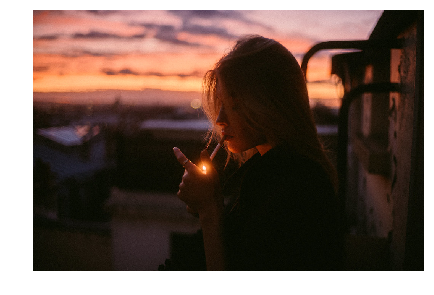

In [183]:
apply_model_to_image_raw_bytes(open("./images/her.jpg", "rb").read())

a man in a suit and tie with a tie


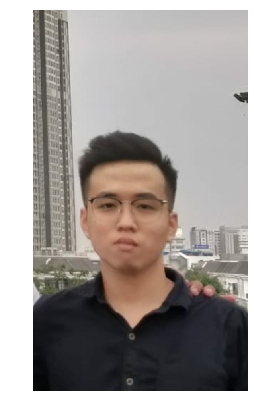

In [184]:
apply_model_to_image_raw_bytes(open("./images/me.jpg", "rb").read())

a woman in a pink shirt and tie


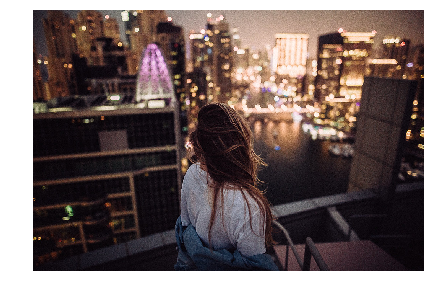

In [185]:
apply_model_to_image_raw_bytes(open("./images/her1.jpg", "rb").read())

a table with a laptop computer and a cup of coffee


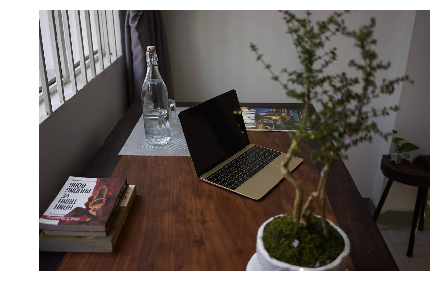

In [186]:
apply_model_to_image_raw_bytes(open("./images/room.jpg", "rb").read())

a man wearing a red shirt and blue shirt and blue tie


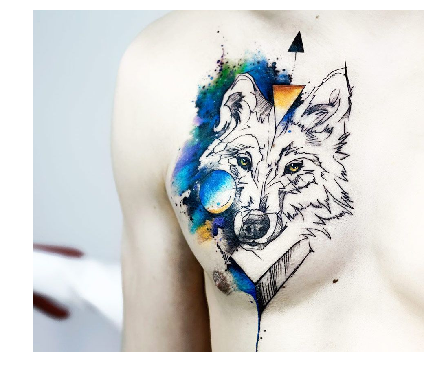

In [187]:
apply_model_to_image_raw_bytes(open("./images/wolf.jpg", "rb").read())

a dog is laying on a bike next to a book


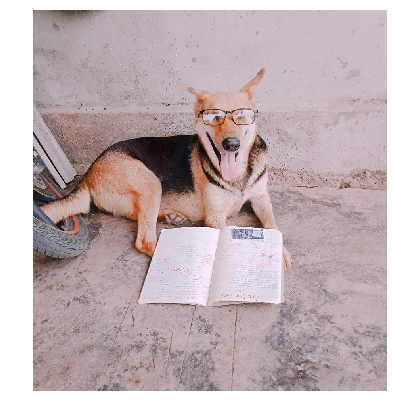

In [188]:
apply_model_to_image_raw_bytes(open("./images/dog.jpg", "rb").read())

a woman holding a glass of wine in front of a glass of wine


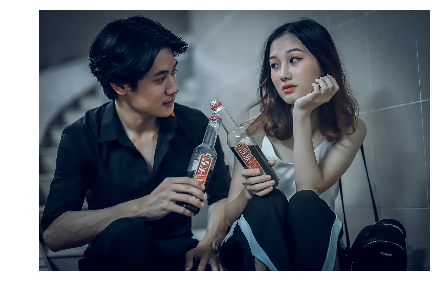

In [189]:
apply_model_to_image_raw_bytes(open("./images/he_she.jpg", "rb").read())

a close up of a black bird with a bird on it


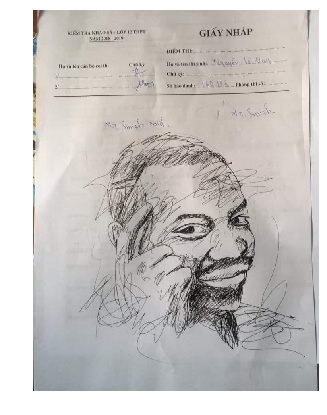

In [190]:
apply_model_to_image_raw_bytes(open("./images/troll.png", "rb").read())

a man and woman sitting on a bench in a room


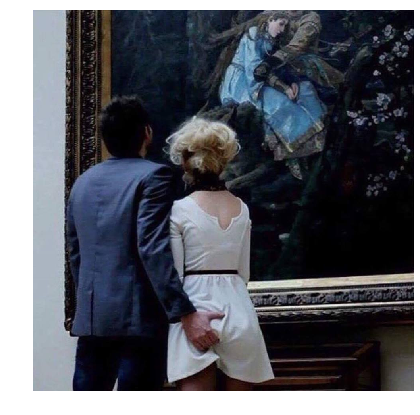

In [191]:
apply_model_to_image_raw_bytes(open("./images/mock.jpg", "rb").read())

a woman wearing a necklace and a necklace


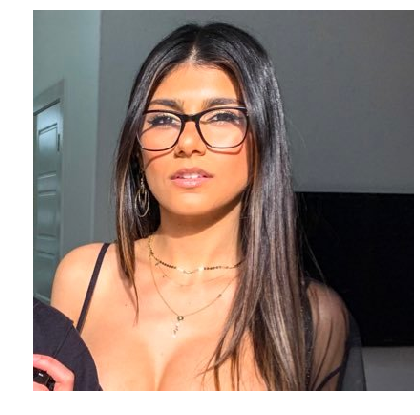

In [192]:
apply_model_to_image_raw_bytes(open("./images/mia.jpg", "rb").read())